In [1]:
!pip install face_recognition

     |████████████████████████████████| 100.1 MB 26 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=d622eb4cec12076bbd300d9e07c7eca159fdc1fe2e8368874de289d8dbb54d81
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tqdm
import face_recognition

In [3]:

def get_distance_from_point_to_line(point, line_point1, line_point2):

        (p,q) = point
        (x1,y1) = line_point1
        (x2,y2) = line_point2

        A = (y2-y1)
        B = (x1-x2)
        
        distance = np.abs( A*p + B*q  - A*x1 - B*y1 ) / np.sqrt( A**2 + B**2 )

        return int(distance)

In [4]:
def get_point_rotation(point,origin,angle):

        (p,q) = point
        (x,y) = origin

        rotated_p = x + np.cos(angle)*(p-x) - np.sin(angle)*(q-y)
        rotated_q = y + np.sin(angle)*(p-x) + np.cos(angle)*(q-y)

        return [int(rotated_p),int(rotated_q)]

In [5]:

def Mask_Faces (image_path,mask_image_path):

  masked_faces_image = Image.open(image_path).convert('RGBA')

  image = face_recognition.load_image_file(image_path)
  mask_img = Image.open(mask_image_path)

  # Get Face Landmark Co-ordinates
  face_landmarks = face_recognition.face_landmarks(image)

  # Return if no Faces found or Required Landmarks not found
  if len(face_landmarks)==0:
    # print("No Faces found in "+image_path.split('/')[-1]+" !")
    return None

  for face in face_landmarks:

    if 'nose_bridge' not in face or 'chin' not in face :
      continue

    # Nose Point (Top of Mask)
    nose_bridge = face['nose_bridge']
    nose_point = ((np.array(nose_bridge[0])+np.array(nose_bridge[1]))/2).astype(np.uint64)

    chin = face['chin']
    chin_len = len(chin)

    # Chin Points (Bottom, Left and Right of Mask)
    chin_bottom_point = np.array(chin[chin_len // 2])       
    chin_left_point = np.array(chin[chin_len // 8])        
    chin_right_point = np.array(chin[chin_len * 7 // 8])

    # Dimensions for the Mask
    width = mask_img.width
    height = mask_img.height        
    width_ratio = 1.15       
    new_mask_height = int(np.linalg.norm(nose_point - chin_bottom_point))

    # Prepare Left Half of the Mask with appropriate Size
    mask_left_img = mask_img.crop((0, 0, width // 2, height))        
    mask_left_width = get_distance_from_point_to_line(chin_left_point, nose_point, chin_bottom_point)        
    mask_left_width = int(mask_left_width * width_ratio)        
    mask_left_img = mask_left_img.resize((mask_left_width, new_mask_height))

        
    # Prepare Right Half of the Mask with appropriate Size
    mask_right_img = mask_img.crop((width // 2, 0, width, height))        
    mask_right_width = get_distance_from_point_to_line(chin_right_point, nose_point, chin_bottom_point)        
    mask_right_width = int(mask_right_width * width_ratio)        
    mask_right_img = mask_right_img.resize((mask_right_width, new_mask_height))

    # Join the 2 Halves to Produce the New Mask Image with the Correct Size
    new_mask_size = (mask_left_img.width + mask_right_img.width, new_mask_height)        
    new_mask_img = Image.new('RGBA', new_mask_size)        
    new_mask_img.paste(mask_left_img, (0, 0), mask_left_img)        
    new_mask_img.paste(mask_right_img, (mask_left_img.width, 0), mask_right_img)

    # Calculate Angle of Rotation (Tilted Face) and Rotate the Mask
    angle_radian = np.arctan2(chin_bottom_point[1] - nose_point[1], chin_bottom_point[0] - nose_point[0])
    rotation_angle_radian = (np.pi/2) - angle_radian
    rotation_angle_degree = (rotation_angle_radian*180)/np.pi
    rotation_center = (mask_left_width,new_mask_height//2)
    rotated_mask_img = new_mask_img.rotate(rotation_angle_degree,expand=True,center = rotation_center)

    # Calcualate Co-ordinates for Pasting the Mask on the Input Image
    center_x = (nose_point[0] + chin_bottom_point[0]) // 2        
    center_y = (nose_point[1] + chin_bottom_point[1]) // 2

    mask_corner_points = [[center_x - mask_left_width, center_y - (new_mask_height//2)],
                          [center_x + mask_right_width, center_y - (new_mask_height//2)],
                          [center_x + mask_right_width, center_y + (new_mask_height//2)],
                          [center_x - mask_left_width, center_y + (new_mask_height//2)]]

    # Make Sure Image Dimentions doesn't exceed 99999 
    rotated_mask_topleft_corner = np.array([99999,99999]) 

    for point in mask_corner_points:

      rotated_mask_topleft_corner = np.minimum(rotated_mask_topleft_corner,
                                    get_point_rotation(point,(center_x,center_y),-rotation_angle_radian))

    # Paste the Mask on Image and Return it
    masked_faces_image.paste(rotated_mask_img,
                            (rotated_mask_topleft_corner[0],rotated_mask_topleft_corner[1]),
                             rotated_mask_img)

    return masked_faces_image

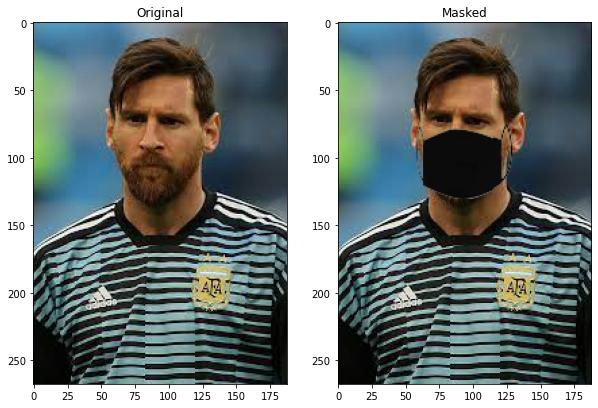

In [6]:

FILE_PATH = "/content/drive/MyDrive/Colab/Social_Distancing/image.jpg"
MASK_IMAGE_PATH = "/content/drive/MyDrive/Colab/Social_Distancing/black_mask.png"

masked_face_image = Mask_Faces(FILE_PATH,MASK_IMAGE_PATH)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(Image.open(FILE_PATH))
plt.subplot(1,2,2)
plt.title("Masked")
plt.imshow(masked_face_image)
plt.show()